In [1]:
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import solve_ivp
from scipy.signal import convolve
from tqdm import tqdm

# Discrete Stochastic Mountain Car

a: -2, force: -0.9640275800758169
a: -1, force: -0.7615941559557649
a: 0, force: 0.0
a: 1, force: 0.7615941559557649
a: 2, force: 0.9640275800758169


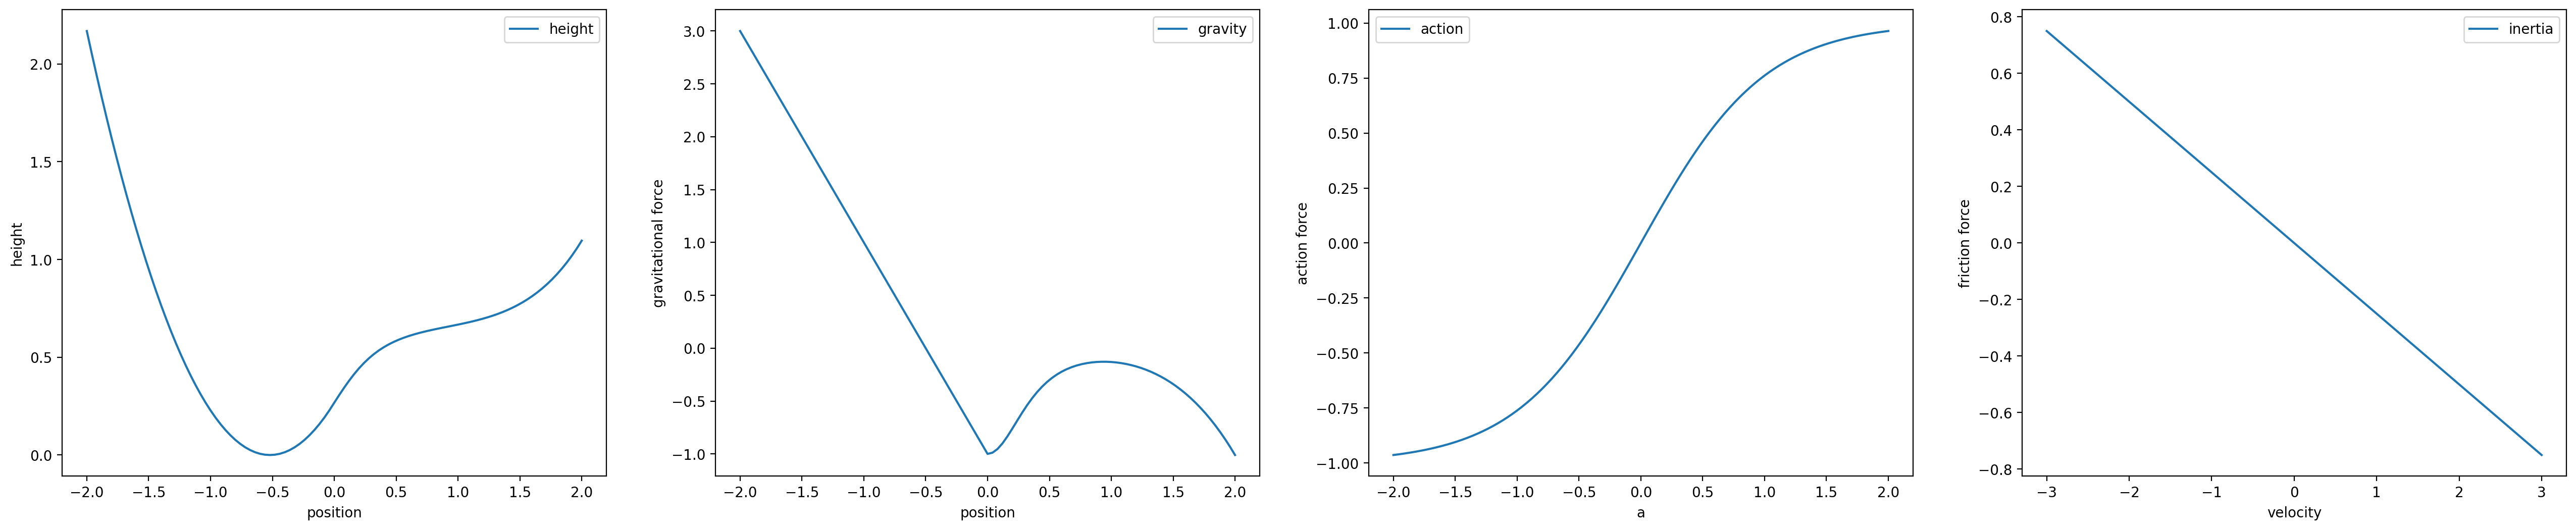

In [2]:
N = 101
x = np.linspace(-2,2, 101)
v = np.linspace(-3,3, 101)

f_action = lambda a: np.tanh(a)

for x in [-2, -1, 0, 1, 2]:
    print(f'a: {x}, force: {f_action(x)}')

def f_gravity(x):
    phi = np.zeros_like(x)
    is_leq0 = x<=0
    phi_1 = 2*x+1
    a = (1 + 5*x**2)
    phi_2 = a**(-0.5)
    phi_3 = - 5*x**2*a**(-1.5)
    phi_4 = (x/2)**4 # negative of paper
    phi = phi_2 + phi_3 + phi_4
    phi[is_leq0] = phi_1[is_leq0]  
    return -phi

N = 101
w = 4/N
x = np.linspace(-2,2,N)
g = f_gravity(x)
h = np.cumsum(-g)*w
h -= h.min()

def height(state):
  pos = np.clip(state[0], x[0], x[-1])
  r = x[-1] - x[0] + 1e-6
  i_x = int((pos-x[0])/r * N)
  #print(pos, r, i_x, h[i_x])
  return h[i_x]

def f_friction(v):
    return -1/4*v

def f(t, s, a):
  dx = s[1]
  f_a = f_action(a)
  f_g = f_gravity(s[0])
  f_i = f_friction(s[1])
  dv = f_a + f_g + f_i 
  #print(f't {t:.2f}, s {s[0,0]:.2f}, {s[1,0]:.2f}, a {a:.2f}, fa {f_a:.2f}, fg {f_g[0]:.2f}, fi {f_i[0]:.2f}')
  return np.array([dx, dv])

xx = np.linspace(-2, 2, 32)
vv = np.linspace(-3, 3, 32)

fig, ax = plt.subplots(1, 4, figsize=(4*8, 6))
plt.sca(ax[0])
plt.plot(x,h, label='height')
plt.xlabel('position')
plt.ylabel('height')
plt.legend()

plt.sca(ax[1])
plt.plot(x, g, label='gravity')
plt.xlabel('position')
plt.ylabel('gravitational force')
plt.legend()

plt.sca(ax[2])
aa = np.linspace(-2, 2, 101)
plt.plot(aa, f_action(aa), label='action')
plt.xlabel('a')
plt.ylabel('action force')
plt.legend()

plt.sca(ax[3])
plt.plot(v, f_friction(v), label='inertia')
plt.xlabel('velocity')
plt.ylabel('friction force')
plt.legend()


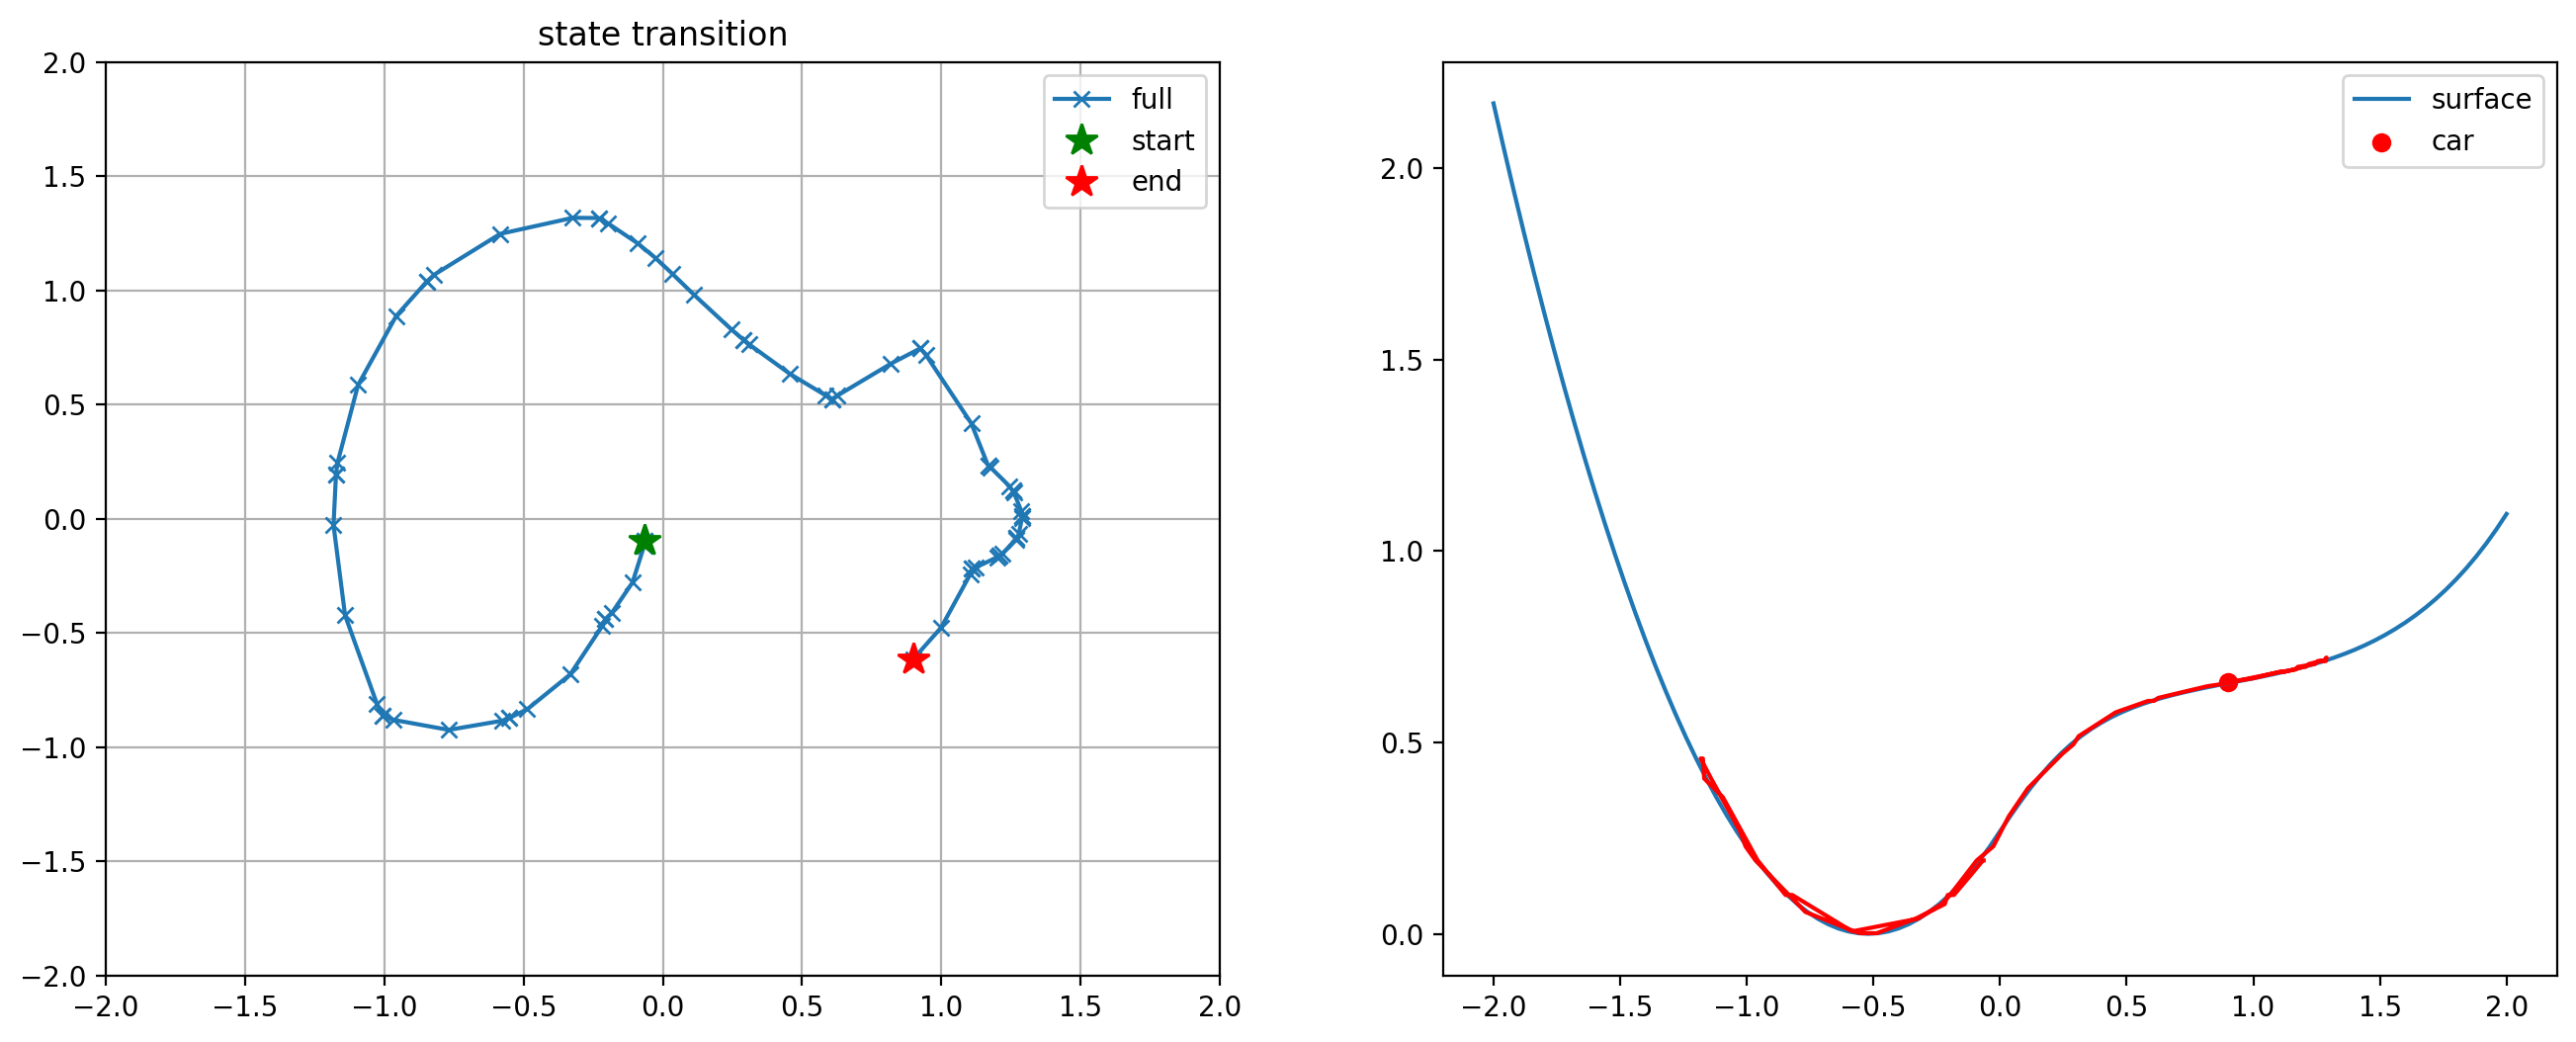

In [3]:
def s1_given_s_a(s, a, debug=False, use_ivp=True):
  if use_ivp:
    sol = solve_ivp(f, t_span=[0.0, 0.5], y0=s, rtol=1e-6, vectorized=True, args=(a,)) # Fig 5: [0, 0.5] with zero action start
  else:
    dt = 0.6
    ds = f(None, np.array(s)[:,np.newaxis], a)
    sol = namedtuple('sol', 'y')
    sol.y = (np.array(s)+ds.squeeze()*dt).reshape((-1,1))
    
  if debug:
    return sol

  return sol.y[:,-1]

s0 = [-0.06451613, -0.09677419]
aa_fig4 = [4, 4, 3, 2, 2, 1, 1, 2, 3, 3, 3, 1, 2, 1, 2] 
        #, 4, 4, 3, 2, 2, 2, 2, 2, 3, 3, 2, 1, 2, 1, 2]
aa_fig5 = [2, 1, 1, 3, 3, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1] #[2, 1, 1, 3, 3, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1]

aa = aa_fig5
a = [-2, -1, 0, 1, 2]
aa = [a[x] for x in aa]

ss = [s0]
ss_full = [s0]
for a in aa:
  sol = s1_given_s_a(s=ss[-1], a=a, debug=True)
  ss.append(sol.y[:,-1])
  ss_full.extend(sol.y.T.tolist())

def plot_trajectory(states, ax=None, label=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(2*10, 5))
  
  xx = [s[0] for s in states]
  vv = [s[1] for s in states]
  hh = np.array([height(s) for s in states])
  hh += np.linspace(0, 1, hh.shape[0]) * 0.00
  
  plt.sca(ax[0])
  plt.plot(xx, vv, 'x-', label=label)
  plt.plot([xx[0]], [vv[0]], 'g*', ms=12, label='start')
  plt.plot([xx[-1]], [vv[-1]], 'r*', ms=12, label='end')
  plt.xlim([-2,2])
  plt.ylim([-2,2])
  plt.title('state transition')
  plt.grid('on')
  plt.legend()
  
  plt.sca(ax[1])
  plt.plot(x,h, label='surface')
  plt.plot(xx, hh, 'r-')
  plt.scatter([xx[-1]], [hh[-1]], color='red', marker='o', label='car')
  plt.legend()
  
fig, ax = plt.subplots(1, 2, figsize=(2*8, 6))
plot_trajectory(ss_full, ax, label='full')
#plot_trajectory(ss, ax, label='steps')


In [4]:
# construct table
n_x, n_v = 32, 32
n_s = n_x * n_v
bounds_x = np.array([-2,2])
bounds_v = np.array([-3,3])
cell_x = (bounds_x[1]-bounds_x[0])/n_x
cell_v = (bounds_v[1]-bounds_v[0])/n_v

def index(x, bounds, nbins):
    r = (bounds[1]-bounds[0]) + 1e-6
    idx = ((x-bounds[0])/r*nbins).astype(int)
    return idx

def value(idx, bounds, nbins):
    r = (bounds[1]-bounds[0])
    w = r / nbins
    return float(idx)/nbins * r + bounds[0] +w/2

def index_x(x):
    return index(x, bounds_x, n_x)

def value_x(x):
    return value(x, bounds_x, n_x)

def index_v(v):
    return index(v, bounds_v, n_v)

def value_v(v):
    return value(v, bounds_v, n_v)

def idx_s_from_idx_xv(x, v):
    return v * n_x + x

def idx_xv_from_idx_s(s):
    x = s % n_x
    v = (s-x) / n_x
    return [int(x), int(v)]

def s_from_index_s(i_s):
    i_x, i_v = idx_xv_from_idx_s(i_s)
    return [value_x(i_x), value_v(i_v)]

def index_s_from_s(s):
    return idx_s_from_idx_xv(index_x(s[0]), index_v(s[1]))

print(n_x, bounds_x, cell_x)
aa = np.array([-2, -1, 0, 1, 2], dtype=int)
n_a = aa.shape[0]

32 [-2  2] 0.125


In [5]:
# uniformly sample s0 in the continuous space when computing transition probabilities
# set velocity to zero if velocity is out of bounds
# clip position to limits

In [6]:
def normalize(p_transition, mode='column'):
  # sum over elements in each row, shaped to normalize correctly
  row_norm = lambda x: np.maximum(x.sum(axis=1).reshape((-1, 1)), 1e-6)
  # sum over elements in each column, shaped to normalize correctly
  column_norm = lambda x: np.maximum(x.sum(axis=0), 1e-6) 
  
  if mode=='column':
    #print('normalize for each column to sum to 1.')
    norm = column_norm
  else:
    #print('normalize for each row to sum to 1.')
    norm = row_norm
    
  if len(p_transition.shape) > 2:
    #print('interpreting axis 0 as action, normalizing each 2D subtensor')
    for a_i in range(p_transition.shape[0]):
      #normalize column-wise
      p = p_transition[a_i]
      l1 = norm(p)
      p = p / l1
      p_transition[a_i] = p
      
    return p_transition
      
  else:
    l1 = norm(p_transition)
    return p_transition / l1

In [7]:
n_samples=10000

p_s0_given_s1_a = np.zeros(shape=(aa.shape[0], n_s, n_s))

# sample states s0
bounds = np.array([bounds_x, bounds_v])
ss0 = np.random.uniform(low=bounds[:,0], high=bounds[:,1], size=(n_samples,2))

for a_i, a in enumerate(aa):
  # compute successor states
  ss1 = []
  for s0 in tqdm(ss0):
    ss1.append(s1_given_s_a(s=s0, a=a))
  
  ss1 = np.array(ss1)
  print(ss1.shape)

  # handle position out of bounds with velocity in same direction
  out_of_bounds_min = np.array(ss1[:,0] <= bounds_x[0]) * np.array(ss1[:,1] < 0)
  out_of_bounds_max = np.array(ss1[:,0] >= bounds_x[1]) * np.array(ss1[:,1] > 0)
  out_of_bounds = np.maximum(out_of_bounds_min, out_of_bounds_max)
  ss1[:,1] = (1-out_of_bounds) * ss1[:,1] # set velocity to zero
  ss1[:,0] = np.clip(ss1[:,0], bounds_x[0], bounds_x[1])
  # handle velocity out of bounds
  ss1[:,1] = np.clip(ss1[:,1], bounds_v[0], bounds_v[1])

  # compute state indices
  ss0_i = index_s_from_s(ss0.T)
  ss1_i = index_s_from_s(ss1.T)

  # build transition matrix
  for s0_i, s1_i in zip(ss0_i, ss1_i):
    p_s0_given_s1_a[a_i, s0_i, s1_i] += 1  

p_backward = normalize(p_s0_given_s1_a)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1503.29it/s]


(10000, 2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1545.37it/s]


(10000, 2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1564.35it/s]


(10000, 2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1564.59it/s]


(10000, 2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1568.09it/s]

(10000, 2)


In [8]:
p_backward = normalize(p_s0_given_s1_a, mode='column')

sum over all preceding states 1.0


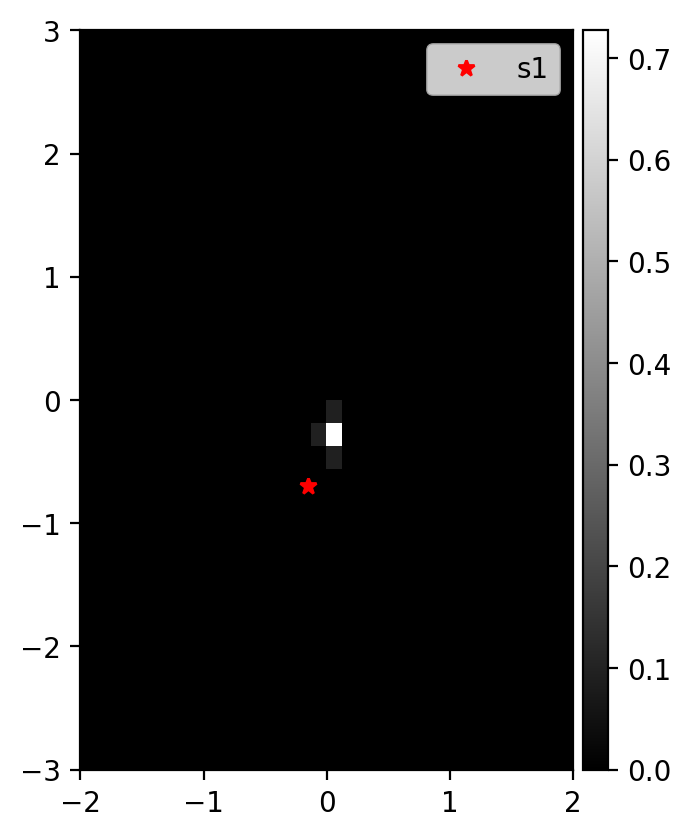

In [9]:
# explore predecessor distribution
s1 = [-0.15, -0.7]
a_i = 2
s1_i = index_s_from_s(s1)
print('sum over all preceding states', p_backward[a_i, :, s1_i].sum())

def show_p_s(p_s, ax=None, cmap='gray'):
  if ax is not None:
    plt.sca(ax)
  else:
    ax = plt.gca()
  
  im = plt.imshow(np.flip(p_s.reshape(n_v, -1), axis=0), cmap=cmap, extent=bounds_x.tolist() + bounds_v.tolist())
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(im, cax=cax)

plt.plot([s1[0]], [s1[1]], 'r*', label='s1', zorder=1)
plt.legend()
show_p_s(p_backward[a_i, :, s1_i])



In [10]:
# possible smoothing of the "pullback" probability
def smooth_transitions(p_pullback):
  p_pullback = np.array(p_pullback)
  kernel = np.array([.25, 0.5, 0.25]).reshape((-1,1))
  show_image = True

  for a_i in range(aa.shape[0]):
    for s1 in range(n_s):
      # guarantee transition (e.g., stay in same spot)
      if p_pullback[a_i, :, s1].sum() < 1e-6:
          p_pullback[a_i, s1, s1] = 1

      # smooth s1
      p = convolve(p_pullback[a_i, :, s1].reshape(n_v, -1), kernel)
      p = convolve(p, kernel.T)
      # saturate transitions at the boundaries
      p[1,:] += p[0,:]
      p[0,:] = 0
      p[-2,:] += p[-1,:]
      p[-1:0] = 0
      p[:,1] += p[:,0]
      p[:,0] = 0
      p[:,-2] += p[:,-1]
      p[:,-1] = 0

      #plt.imshow(p, cmap='gray')
      #print(p.sum(), p.shape)
      transition = p[1:-1,1:-1]
      if show_image and (np.random.uniform() < 0.01):
        fig, ax = plt.subplots(1, 3, figsize=(3*6, 8))
        plt.sca(ax[0])
        show_p_s(p_pullback[a_i, :, s1])
        plt.sca(ax[1])         
        show_p_s(transition.reshape(-1))
        plt.sca(ax[2])
        show_p_s(transition.reshape(-1) - p_pullback[a_i, :, s1], cmap='viridis')
        show_image=False

      #print(transition.sum())
      p_pullback[a_i, :, s1] = transition.reshape(-1)

  p_pullback = normalize(p_pullback)

  return p_pullback

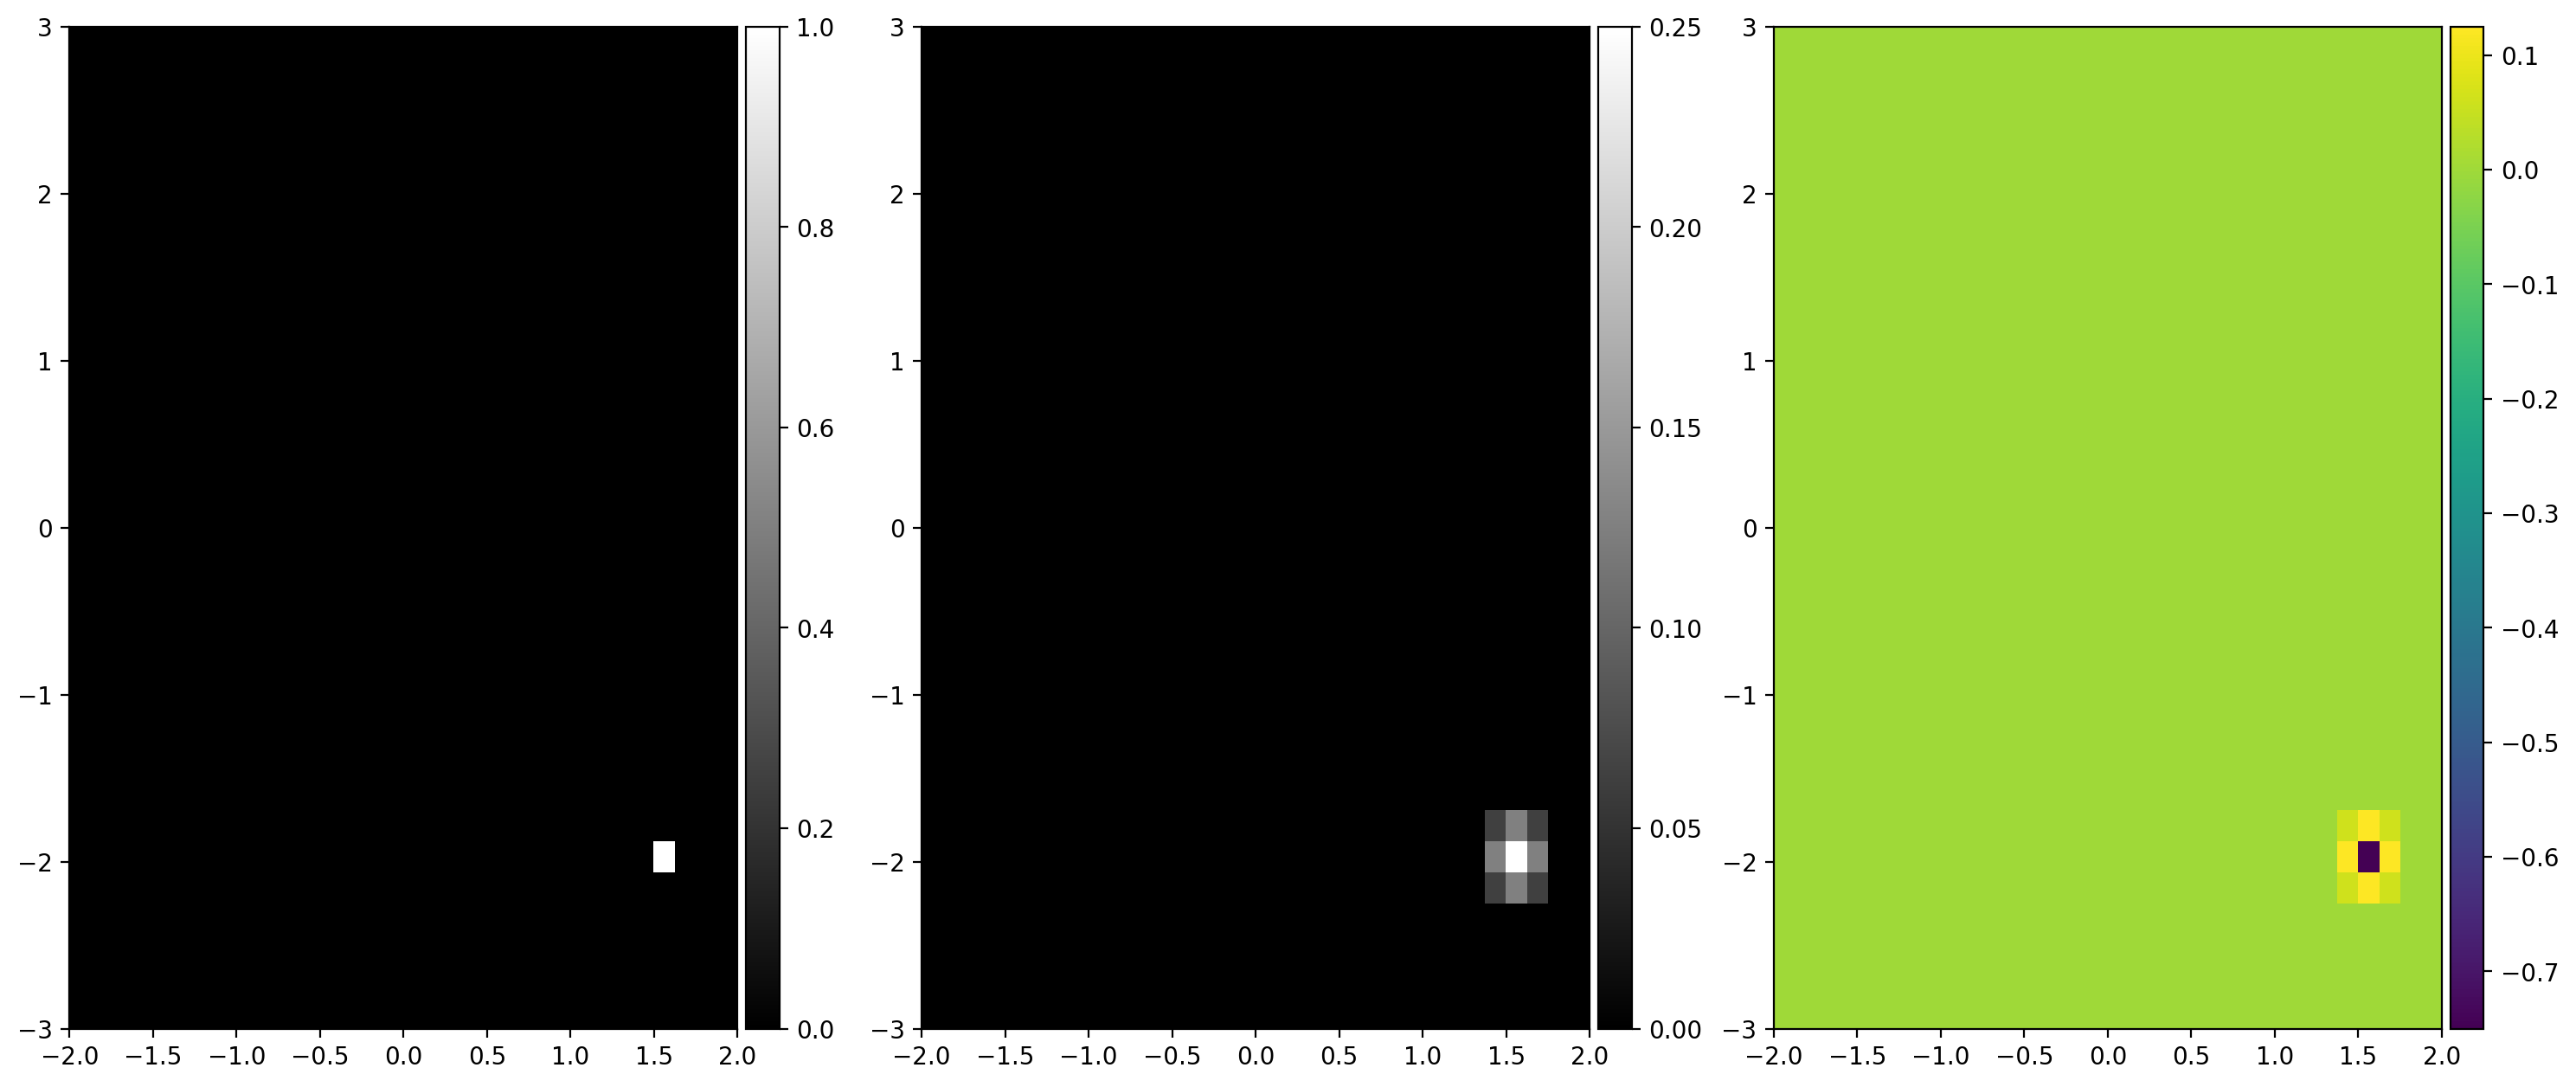

In [11]:
p_smoothed = smooth_transitions(p_backward)

1.0
0.9999990000010002
0.9999990000000002
0.9999989999999999
0.9999990000000001
0.9999990000000001
0.9999990000000001
0.999999
0.999999


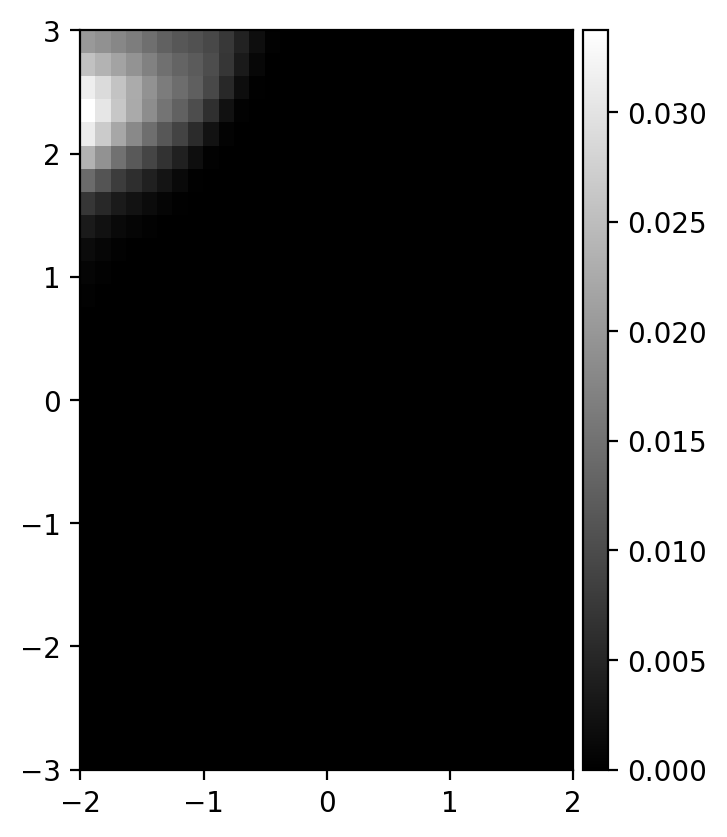

In [12]:
# simulate multiple-steps belief updating backwards in time
s1 = np.array([1,0])
i_s1 = index_s_from_s(s1)
b = np.zeros(n_s)
b[i_s1] = 1.
p_transition = [p_smoothed, p_s0_given_s1_a][0]

#p = p_s0_given_a_s1[i_s1]
for i in range(8):
    print(b.sum())
    #b = np.dot(p_pullback[2].T, b)
    b = np.dot(p_transition[0], b)
    #b = np.dot(b, p_pullback[1])
    b = b / (np.sum(b) + 1e-6)
    
show_p_s(b)
print(b.sum())

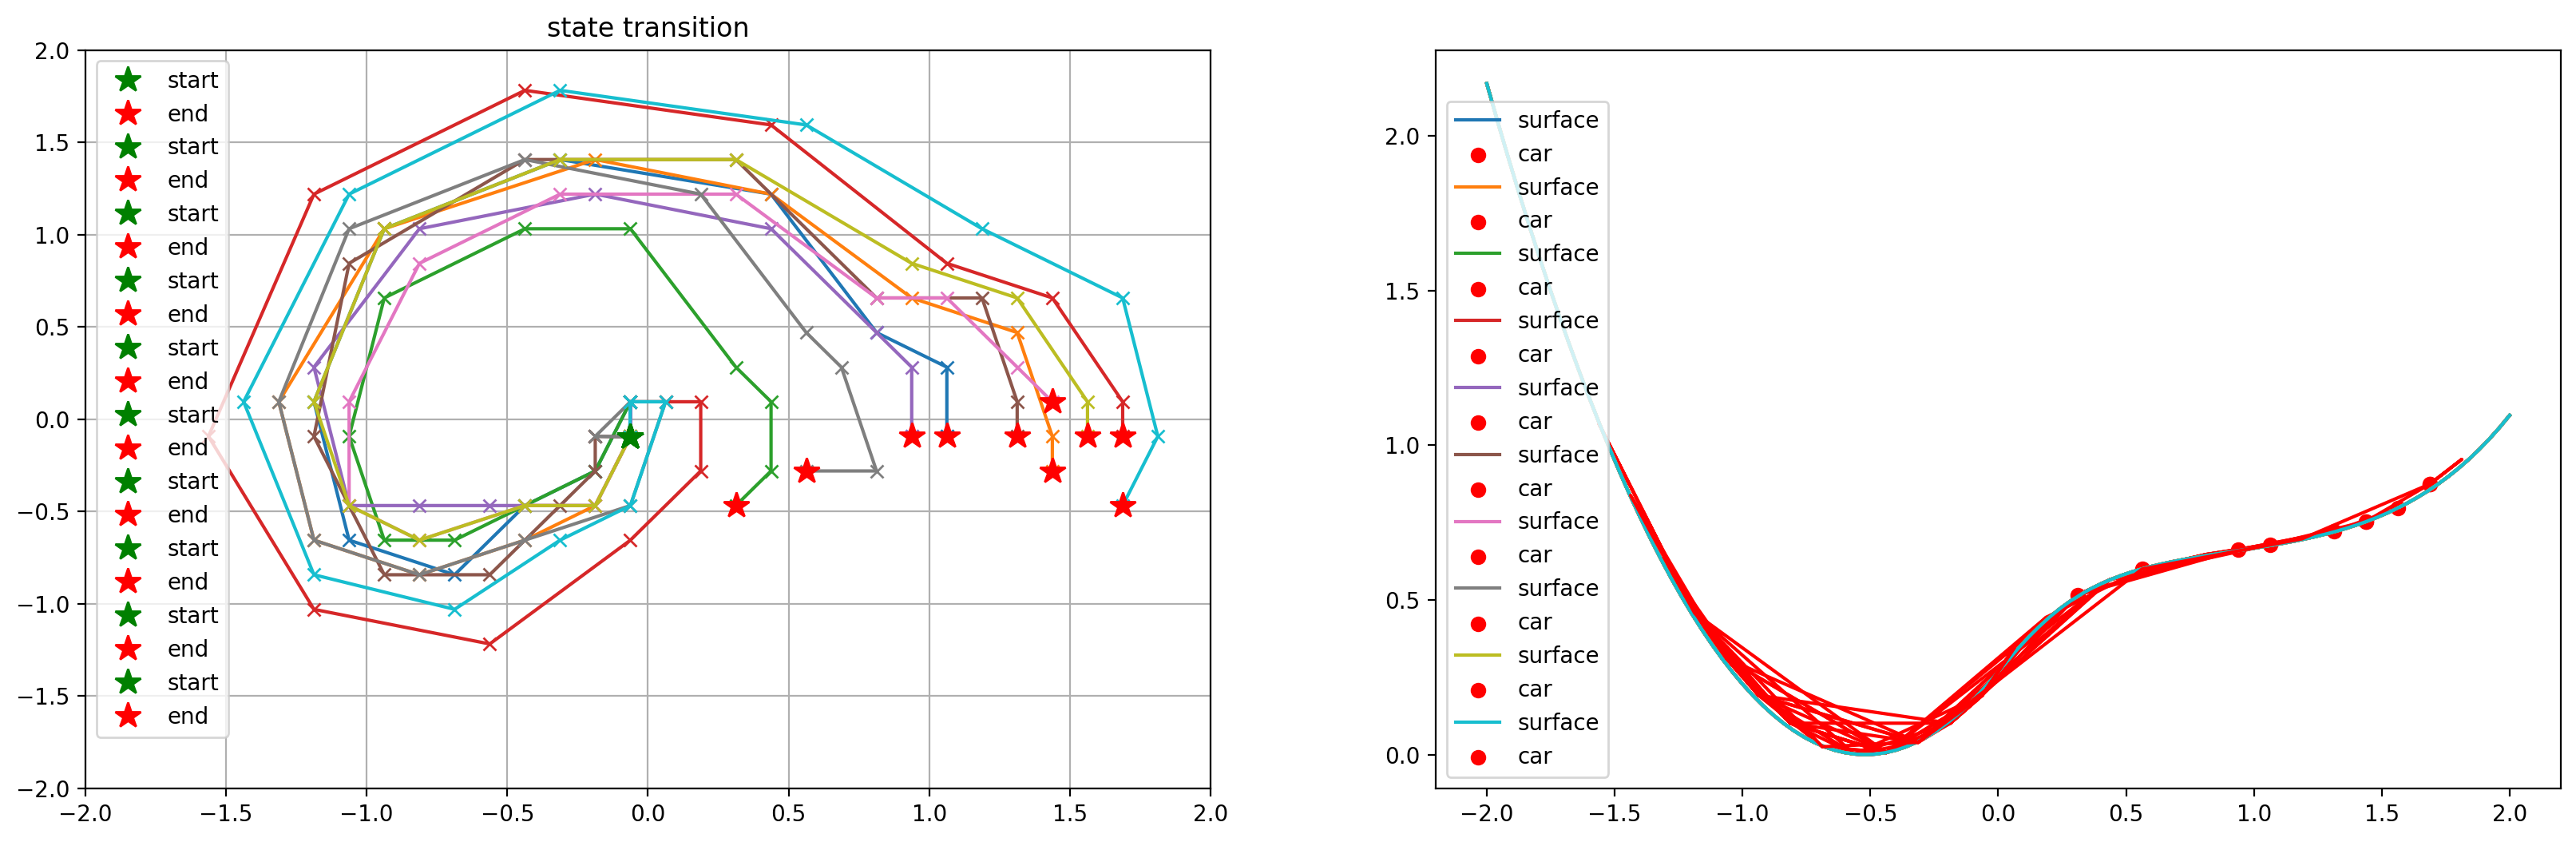

In [13]:
# sample forward
s0 = [-0.06451613, -0.09677419]
aa_fig4 = [4, 4, 3, 2, 2, 1, 1, 2, 3, 3, 3, 1, 2, 1, 2] 
        #, 4, 4, 3, 2, 2, 2, 2, 2, 3, 3, 2, 1, 2, 1, 2]
aa_fig5 = [2, 1, 1, 3, 3, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1] #[2, 1, 1, 3, 3, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1]
aa_i = aa_fig4

# sample forward dynamics
p_transition = [p_smoothed, p_backward][1]
p_forward = normalize(np.array(p_transition), mode='row')

fig, ax = plt.subplots(1, 2, figsize=(2*10, 6))

for _ in range(10):
  ss = [s0]
  s_i = index_s_from_s(s0)
  for a_i in aa_i:
    s_i = np.random.choice(n_s, p=p_forward[a_i, s_i,:])
    ss.append(s_from_index_s(s_i))

  plot_trajectory(ss, ax=ax)

# Agency-based Optimisation

In [14]:
n_s # number of states
n_a # number of actions
k = 0 # current timestep
T = 16 # planning horizon
s0 = [0, 0]# initial state
s0_i = index_s_from_s(s0) # index of initial state
p_s0 = np.zeros(n_s)
p_s0[s0_i] = 1

sT = [1, 0] # target final hidden state
sT_i = index_s_from_s(sT) # index of target state
p_sT = np.zeros(n_s)
p_sT[sT_i] = 1 # prior over final hidden state - c

# A: identity
# priors (c, d in Eq. 12)
p_a = np.ones(n_a)/n_a# prior belief/ cost over control states - d
p_s = np.ones(n_s)/n_s# prior belief/ cost over intermediate future states ????

# initial beliefs: initialize them at random???
b_a = np.tile(p_a, (T, 1)) # u_t
b_s = np.tile(p_s, (T, 1)) # beliefs over states across timesteps (t, s): alpha_t
b_s[-1,:] = p_sT # set belief of final state to prior
b_s[0,:] = p_s0

# log action prior
log_p_a = np.log(p_a)

# Equation 15

# variational energy I of state s_t is expectation over terms
# 1) ln P(o_t|s_t), for executed timesteps t
#    - in our case, this is 1 because the environment is fully observed.
#    - can be pulled out of the expectation
# 2) ln P(s_t|s_t+1, u_t+1)
#    - expectation over both s_t+1 and u_t+1
#    - for each possible action: probability of taking that action * action-dependent transition p(s_t|s_t+1), with belief over s_t+1
# 3) Expectation over Q(s_t-1) and Q(u_t) ln P(s_t-1|s_t, u_t)
#    - expectation over s_t-1 and u_t
#    - for each possible action: probability of taking that action * action_dependent transition p(s_t-1|s_t) with belief over s_t-1
def variational_energy_s(t, b_a, b_s, p_backward):
  # is observed? add one
  b_a_next = b_a[t+1]
  b_a_now = b_a[t]
  b_s_next = b_s[t+1]
  b_s_prev = b_s[t-1]
  
  first = np.dot(b_a_next, np.dot(p_backward, b_s_next))
  #print('first', first)
  second = np.dot(b_a_now, np.dot(b_s_prev, p_backward))
  #print('second', second)
  return np.log(np.maximum(first, 1e-6)) + np.log(np.maximum(second, 1e-6))

# variational energy I over control state u_t,i is expectation oer beliefs about
# s_t-1 and s_t
# 1) ln P(s_t-1|s_t, u_t)
#    - expectation over s_t-1 and s_t, fixed u_t
# 2) ln P(u_t)
#    - can be pulled out of expectation
def variational_energy_a_i(t, i, b_s, p_backward, log_p_a):
  b_s_now = b_s[t]
  b_s_prev = b_s[t-1]
  first = np.dot(b_s_prev, np.dot(p_backward[i,:,:], b_s_now))
  second = log_p_a[i]
  return np.log(first) + second

def agency_based_selection(b_s, b_a, debug=False):
  n_steps = 64 # optimization ('until convergence')
  bb_s = [np.copy(b_s)] # tracking progress
  bb_a = [np.copy(b_a)] # tracking progress

  #for k in range(T-1):
  #print('k', k)
  for _ in range(n_steps): # repeat until convergence
    for t in reversed(range(k+1, T-1, 1)):
      log_i_s = variational_energy_s(t, b_a, b_s, p_backward)
      log_i_a = np.array([variational_energy_a_i(t, i, b_s, p_backward, log_p_a) for i in range(n_a)])
      b_a[t] = np.exp(log_i_a)
      b_s[t] = np.exp(log_i_s)

      b_s[t] = b_s[t]/b_s[t].sum()
      b_a[t] = b_a[t]/b_a[t].sum()

    bb_a.append(np.copy(b_a))
    bb_s.append(np.copy(b_s))

  #plt.subplots()
  #plt.imshow(bb_a[-1].T, cmap='gray')  
  if debug == True:
    return bb_a[-1][1], bb_a, bb_s
  
  return bb_a[-1][1]

NameError: name 'log_p_backward' is not defined

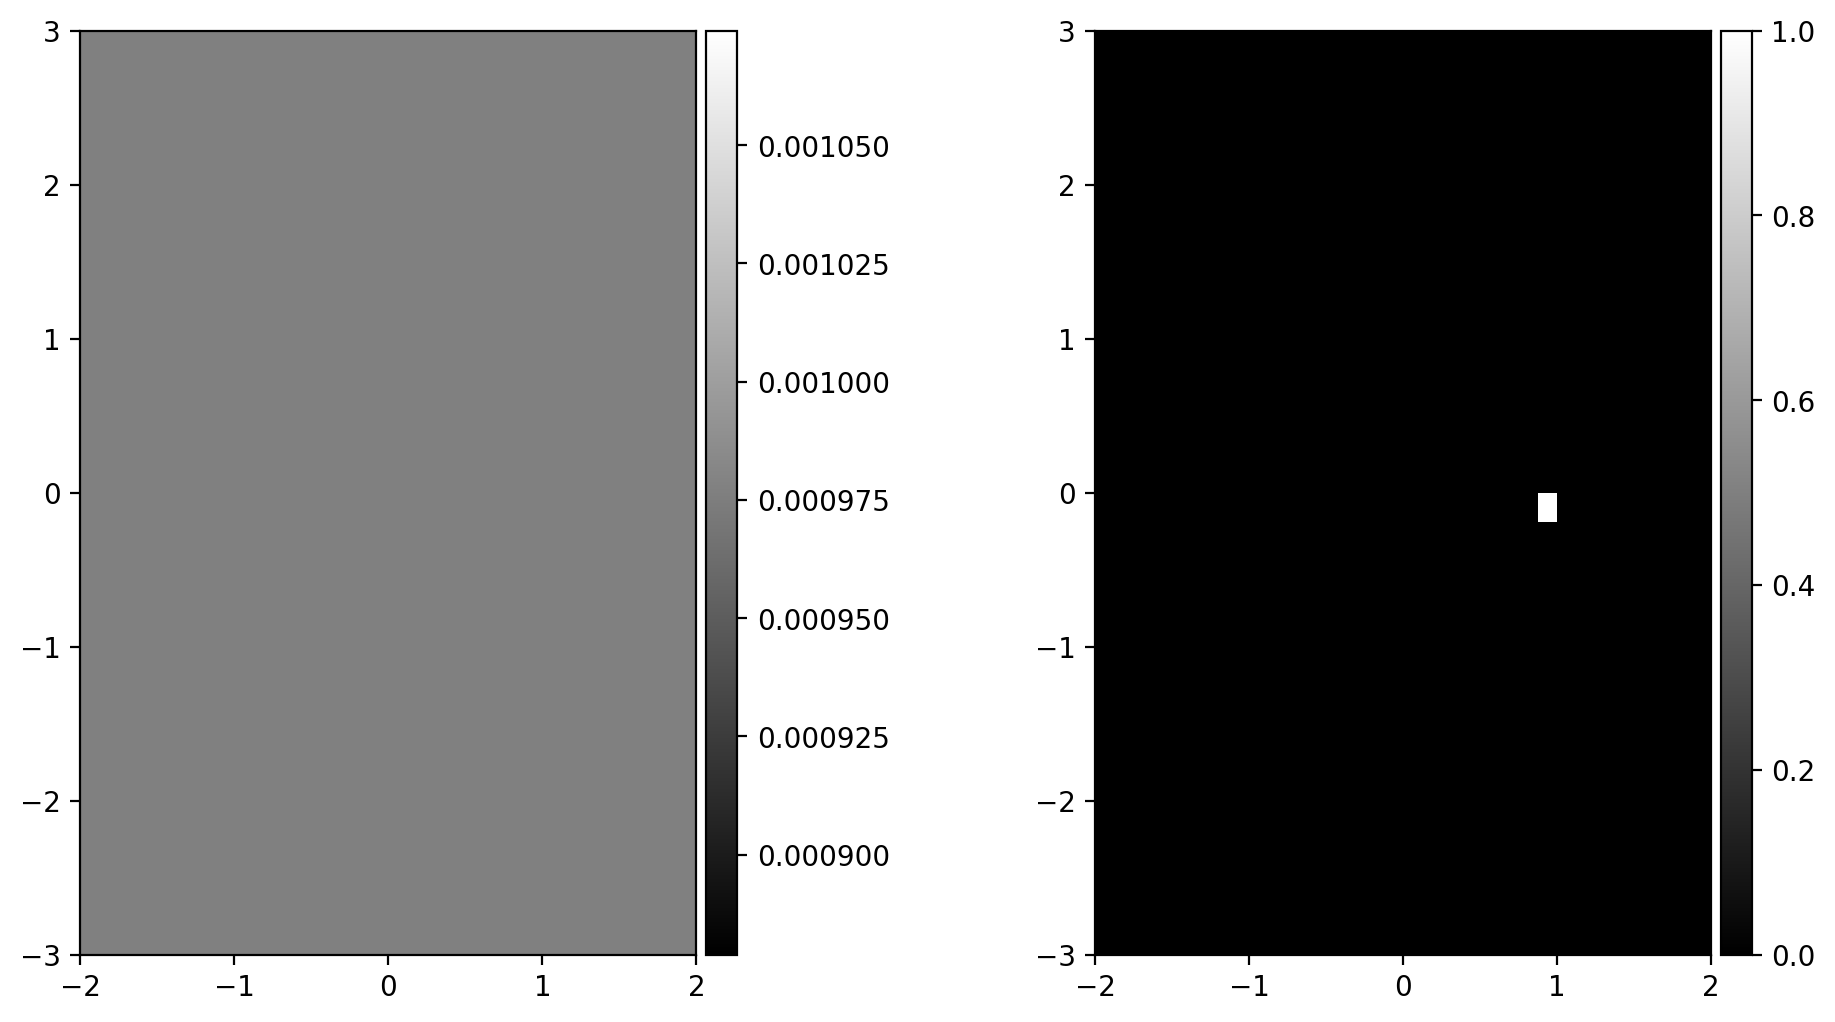

In [15]:
t = T-2 # index of second to last state
b_a_next = b_a[t+1]
b_a_now = b_a[t]
b_s_next = b_s[t+1]
b_s_prev = b_s[t-1]

fig, ax = plt.subplots(1, 2, figsize=(2*6, 6))
show_p_s(b_s_prev, ax=ax[0])
show_p_s(b_s_next, ax=ax[1])

first = np.dot(b_a_next, np.dot(log_p_backward, b_s_next))
print(first.shape, first)
second = np.dot(b_a_now, np.dot(b_s_prev, log_p_backward))
print(first.shape, first)

In [ ]:
p_a_next, bb_a, bb_s = agency_based_selection(b_s, b_a, debug=True)
print('next action', p_a_next)
a_i = np.argmax(p_a_next)
s_i = np.random.choice(n_s, p=p_forward[a_i, s_i,:]) # step


In [ ]:
plt.imshow(bb_a[-1].T, cmap='gray')

In [ ]:
#np.array(bb_s)
#for b_s in bb_s:
#  plt.figure()
#  show_p_s(b_s[1])
  
#plt.imshow(np.array(bb_s)[:,1,:], aspect='auto')
plt.imshow(np.array(bb_s)[-1,:,:], aspect='auto')

In [ ]:
b_s.shape